In [3]:
# Essentials
import os
import random
import numpy as np
import pandas as pd
from collections import Counter

# Images
from PIL import Image

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from skimage import transform, exposure, io
from skimage.feature import hog
from skimage.transform import resize

#Accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, silhouette_score

print("Setup Complete")

Setup Complete


### Splitting Dataset

In [4]:
# bins=[0, 18, 50, 80, float('inf')]
def age_range(filename):
    age = int(filename.split('_')[0].split('/')[-1])
    
    if age < 18:
        return "0-17"
    elif age < 50:
        return "18-49"
    elif age < 80:
        return "50-79"
    else:
        return "80+"


dataset_path = 'src/utkface/'

all_images = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path)]

ages = [age_range(filename) for filename in all_images]

train_images, test_images = train_test_split(all_images, test_size=0.3, stratify=ages ,random_state=42)

In [5]:
train_age_distribution = Counter(age_range(filename) for filename in train_images)
print("Training set age distribution:", train_age_distribution)

test_age_distribution = Counter(age_range(filename) for filename in test_images)
print("Testing set age distribution:", test_age_distribution)

Training set age distribution: Counter({'18-49': 10140, '50-79': 3022, '0-17': 2962, '80+': 471})
Testing set age distribution: Counter({'18-49': 4346, '50-79': 1295, '0-17': 1270, '80+': 202})


#### Create Test Data

In [6]:
test_age = []
test_gender = []
test_image_path = []
test_race = []


for filename in test_images:
    temp = filename.split('_')
    data_age = temp[0].split('/')[-1]
    data_gender = temp[1]
    data_race = temp[2]
    if(data_gender not in ["0","1"] or data_race not in ["0","1","2","3","4"]):
        continue
    test_age.append(data_age)
    test_gender.append(data_gender)
    test_race.append(data_race)
    test_image_path.append(filename)    

test_df = pd.DataFrame()
test_df['image'],test_df['age'],test_df['gender'],test_df['race'] = test_image_path,test_age,test_gender,test_race
test_df.head(5)

image age gender race
0  src/utkface/42_1_1_20170113011527191.jpg.chip.jpg  42      1    1
1  src/utkface/80_1_0_20170117155129695.jpg.chip.jpg  80      1    0
2  src/utkface/69_0_0_20170104185333726.jpg.chip.jpg  69      0    0
3   src/utkface/2_1_3_20161219230338336.jpg.chip.jpg   2      1    3
4  src/utkface/18_0_3_20170117135605224.jpg.chip.jpg  18      0    3

## Loading Images

In [7]:
age = []
gender = []
image_path = []
race = []


for filename in train_images:
    temp = filename.split('_')
    data_age = temp[0].split('/')[-1]
    data_gender = temp[1]
    data_race = temp[2]
    if(data_gender not in ["0","1"] or data_race not in ["0","1","2","3","4"]):
        continue
    age.append(data_age)
    gender.append(data_gender)
    race.append(data_race)
    image_path.append(filename)    
    print(filename,data_age,data_gender,data_race)

src/utkface/11_0_0_20170110220518578.jpg.chip.jpg 11 0 0
src/utkface/56_1_0_20170110141232209.jpg.chip.jpg 56 1 0
src/utkface/24_1_2_20170116171657075.jpg.chip.jpg 24 1 2
src/utkface/57_1_0_20170109134603312.jpg.chip.jpg 57 1 0
src/utkface/8_1_0_20170109205030055.jpg.chip.jpg 8 1 0
src/utkface/26_1_2_20170116180234218.jpg.chip.jpg 26 1 2
src/utkface/26_1_0_20170117174358903.jpg.chip.jpg 26 1 0
src/utkface/70_0_0_20170104213651117.jpg.chip.jpg 70 0 0
src/utkface/53_1_1_20170112215257791.jpg.chip.jpg 53 1 1
src/utkface/39_1_0_20170105164520316.jpg.chip.jpg 39 1 0
src/utkface/30_0_1_20170117202825454.jpg.chip.jpg 30 0 1
src/utkface/8_1_0_20170104005606487.jpg.chip.jpg 8 1 0
src/utkface/30_0_4_20170103235622469.jpg.chip.jpg 30 0 4
src/utkface/41_0_0_20170104204845308.jpg.chip.jpg 41 0 0
src/utkface/1_0_2_20161219162514182.jpg.chip.jpg 1 0 2
src/utkface/25_1_4_20161220222242243.jpg.chip.jpg 25 1 4
src/utkface/26_1_4_20170117201855518.jpg.chip.jpg 26 1 4
src/utkface/60_1_1_20170120222504473.

In [8]:
df = pd.DataFrame()
df['image'],df['age'],df['gender'],df['race'] = image_path,age,gender,race
df.head(5)

image age gender race
0  src/utkface/11_0_0_20170110220518578.jpg.chip.jpg  11      0    0
1  src/utkface/56_1_0_20170110141232209.jpg.chip.jpg  56      1    0
2  src/utkface/24_1_2_20170116171657075.jpg.chip.jpg  24      1    2
3  src/utkface/57_1_0_20170109134603312.jpg.chip.jpg  57      1    0
4   src/utkface/8_1_0_20170109205030055.jpg.chip.jpg   8      1    0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16594 entries, 0 to 16593
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   16594 non-null  object
 1   age     16594 non-null  object
 2   gender  16594 non-null  object
 3   race    16594 non-null  object
dtypes: object(4)
memory usage: 518.7+ KB


In [10]:
print(df.shape)
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:"Asian", 3:"Indian", 4:"Others"}

(16594, 4)


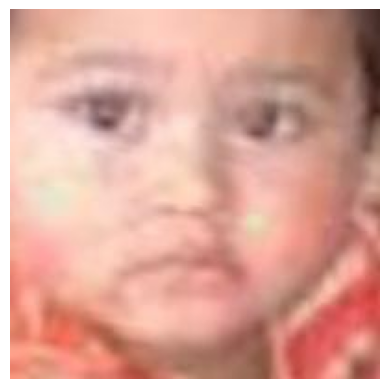

In [11]:
img = Image.open(df.sample().values[0,0])
plt.axis("off")
plt.imshow(img)

## Preprocessing

#### Handling Incomplete rows

In [12]:
df['gender'].value_counts()

gender
0    8638
1    7956
Name: count, dtype: int64

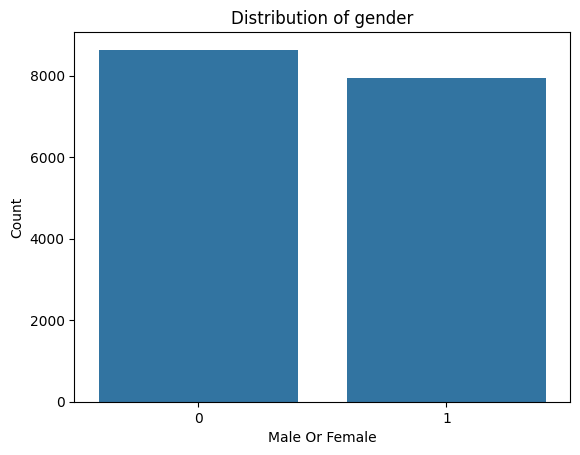

In [13]:
sns.countplot(x=df['gender'], data=df)
plt.title('Distribution of gender')
plt.xlabel('Male Or Female')
plt.ylabel('Count')
plt.show()

In [14]:
df['image']

0        src/utkface/11_0_0_20170110220518578.jpg.chip.jpg
1        src/utkface/56_1_0_20170110141232209.jpg.chip.jpg
2        src/utkface/24_1_2_20170116171657075.jpg.chip.jpg
3        src/utkface/57_1_0_20170109134603312.jpg.chip.jpg
4         src/utkface/8_1_0_20170109205030055.jpg.chip.jpg
                               ...                        
16589    src/utkface/30_0_3_20170117120456566.jpg.chip.jpg
16590     src/utkface/1_0_2_20161219151505283.jpg.chip.jpg
16591    src/utkface/26_0_4_20170117195915493.jpg.chip.jpg
16592     src/utkface/6_0_2_20161219190713643.jpg.chip.jpg
16593    src/utkface/12_1_2_20170116194059753.jpg.chip.jpg
Name: image, Length: 16594, dtype: object

In [15]:
duplicate_rows = df[df.duplicated(subset=['image'] , keep=False)]
duplicate_rows

# there are no duplicate images

Empty DataFrame
Columns: [image, age, gender, race]
Index: []

In [16]:
df['age'].value_counts()

age
26     1529
1       791
28      636
35      628
24      596
       ... 
110       3
105       3
101       2
116       1
91        1
Name: count, Length: 101, dtype: int64

In [17]:
df['race'].value_counts()


race
0    7034
1    3162
3    2808
2    2403
4    1187
Name: count, dtype: int64

In [18]:
df['age'] = df['age'].astype(int)
df['race'] = df['race'].astype(int)
df['gender'] = df['gender'].astype(int) 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16594 entries, 0 to 16593
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   16594 non-null  object
 1   age     16594 non-null  int32 
 2   gender  16594 non-null  int32 
 3   race    16594 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 324.2+ KB


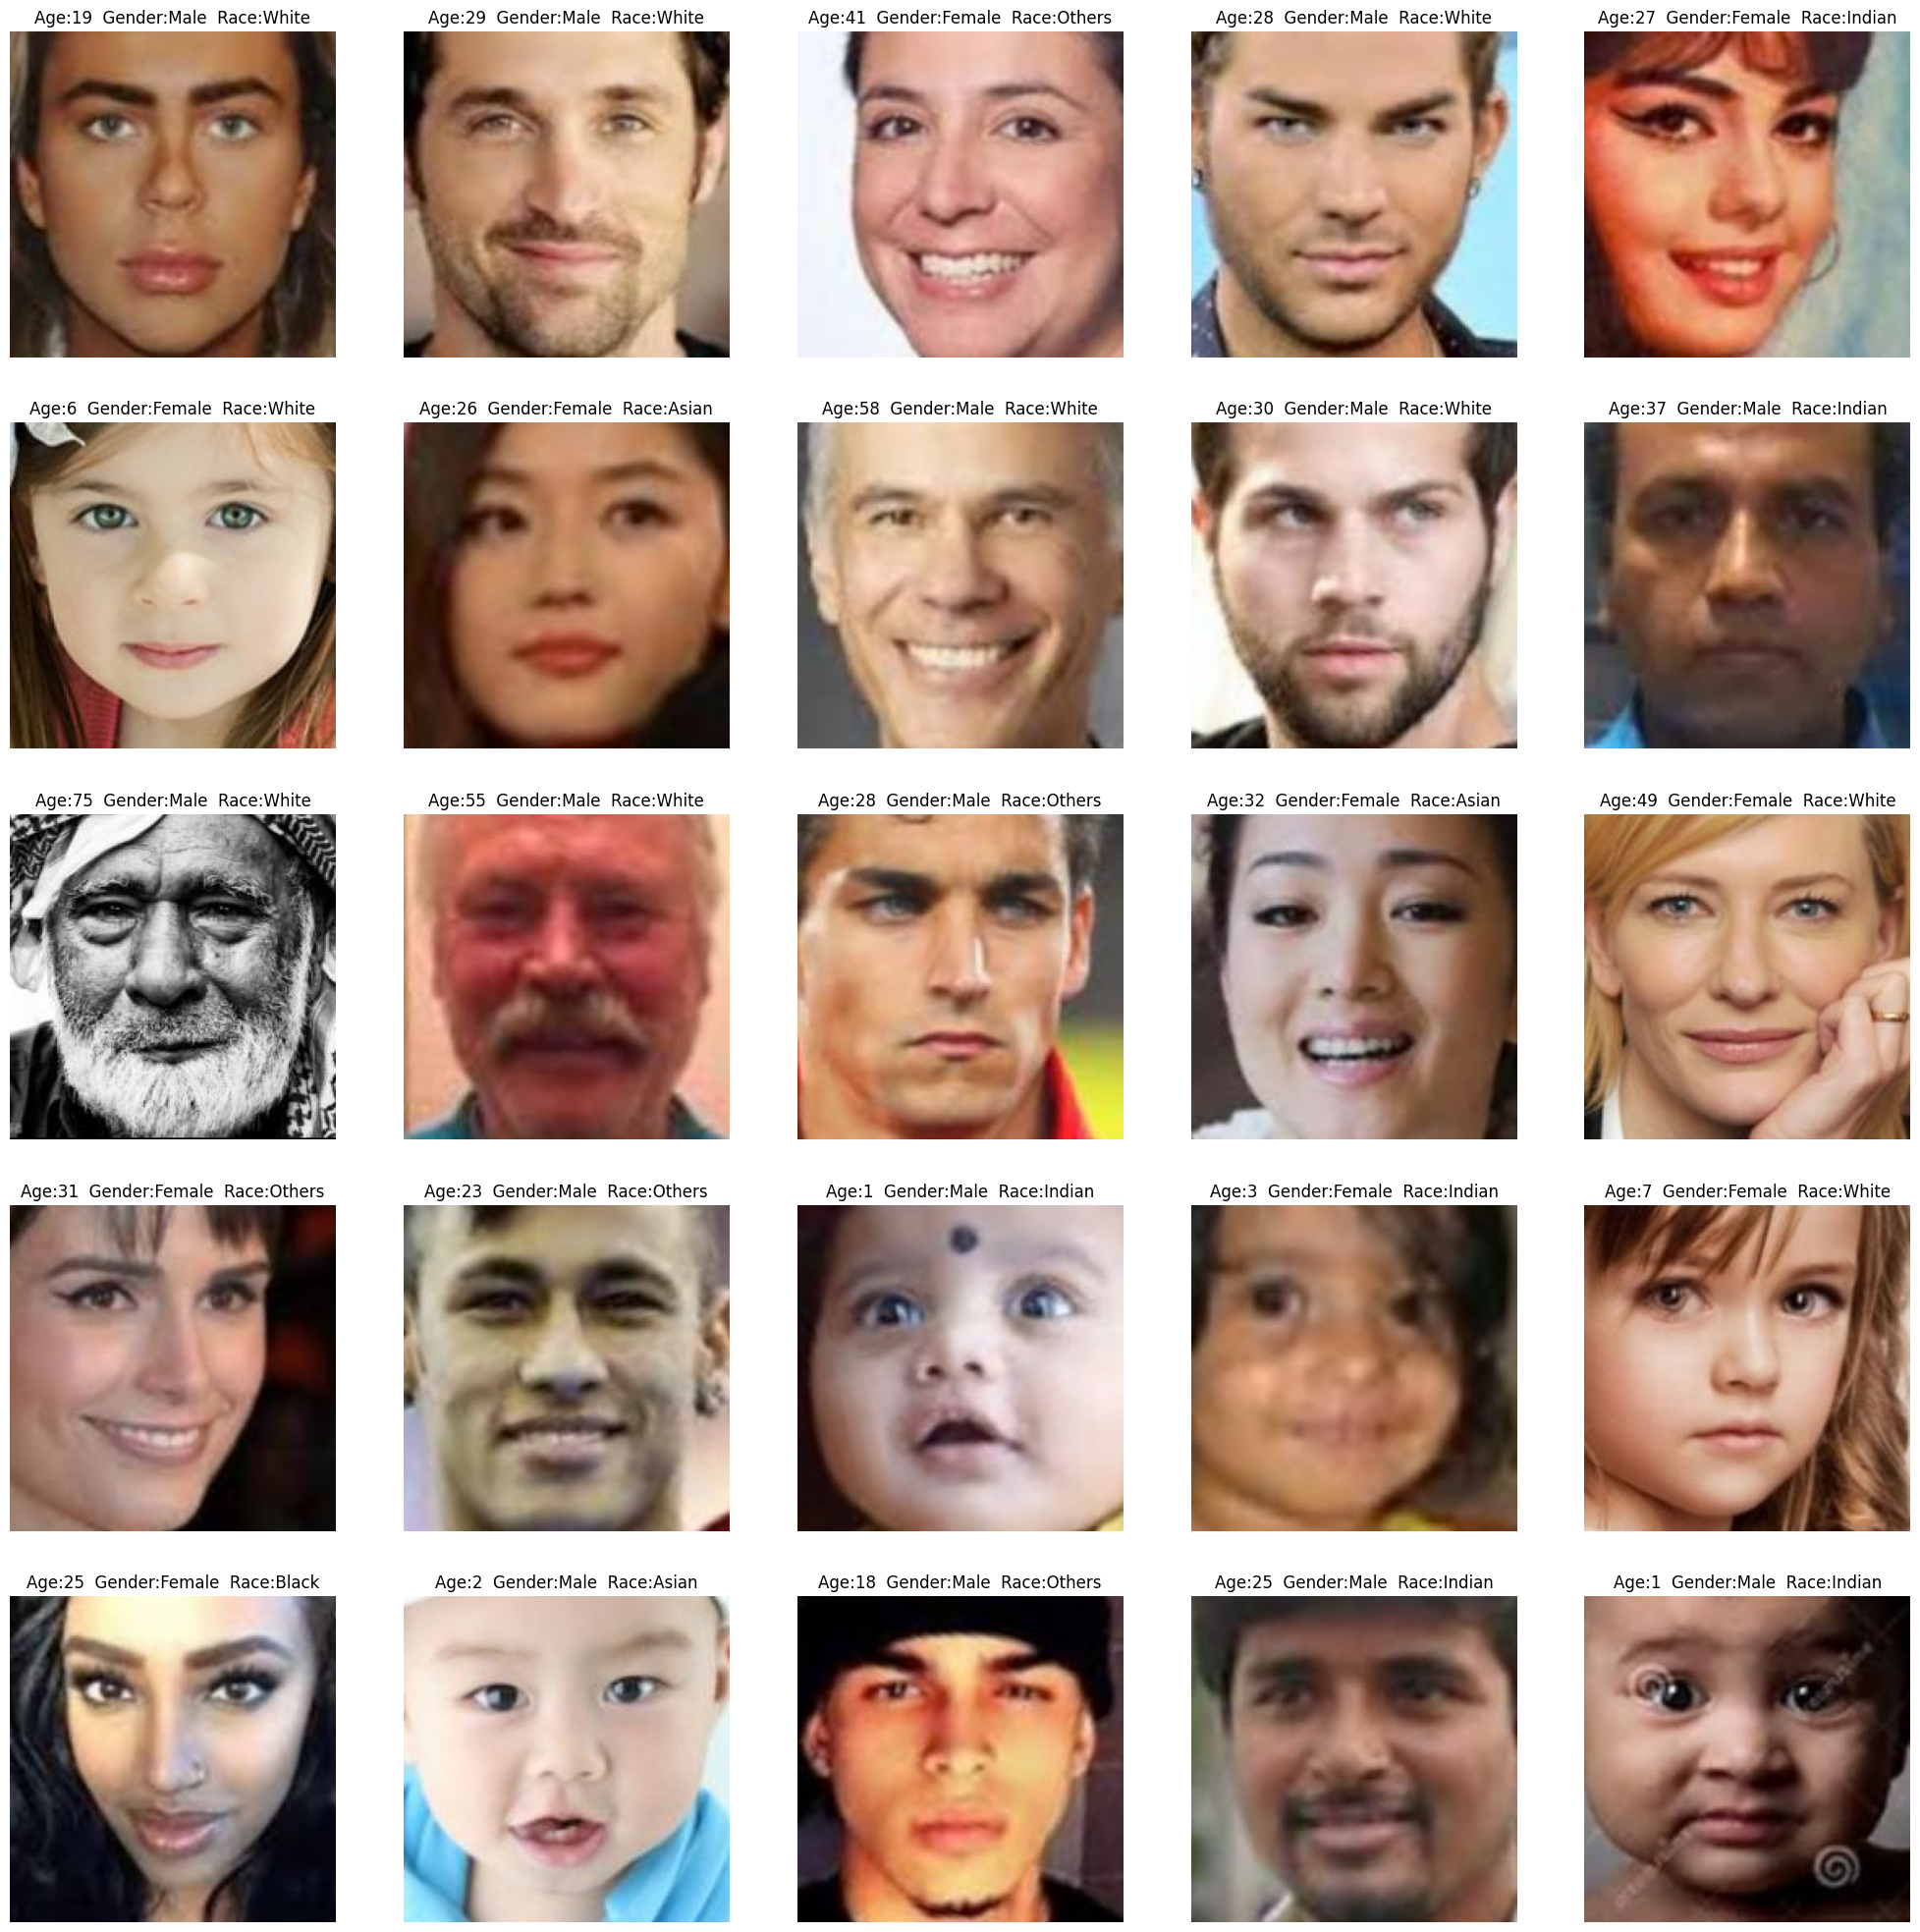

In [20]:
rand = random.randint(0,len(df.index)-25)
files = df.iloc[rand:rand+25]

plt.figure(figsize=(25,25))

i = 0
for index,file,age,gender,race in files.itertuples():
    plt.subplot(5,5,i+1)
    img = Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age}  Gender:{gender_dict[gender]}  Race:{race_dict[race]}")
    plt.axis('off')
    i+=1

In [21]:
#HOG Function

def compute_hog_features(image_paths):
    hog_features_list = []
    
    for path in image_paths:
        image = io.imread(path, as_gray=True)
        resized_image = transform.resize(image, (64, 64))
        hog_features = hog(resized_image, orientations=9, feature_vector=True)
        
        hog_features_list.append(hog_features)
    
    return hog_features_list

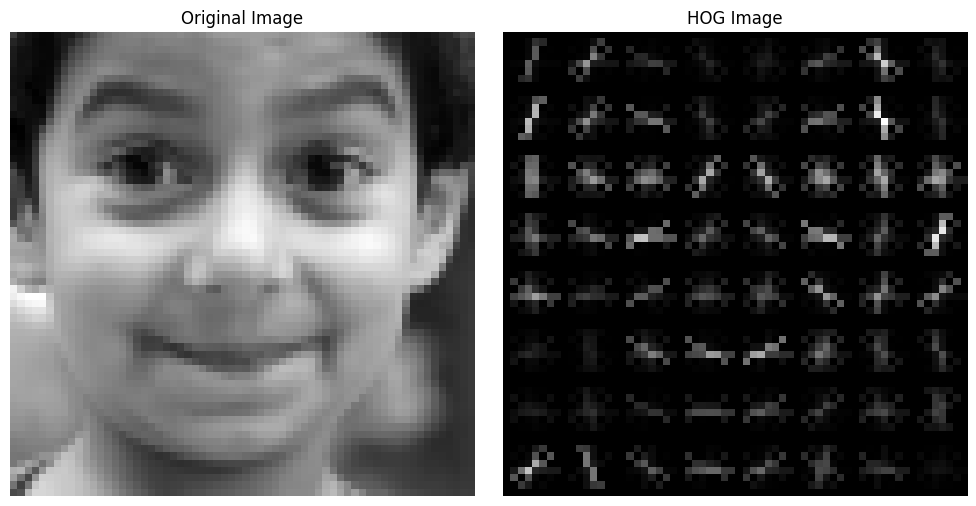

In [22]:
#Test for image

rand = random.randint(0,len(df.index))
image = io.imread(df['image'][rand], as_gray=True)

resized_image = resize(image, (64, 64))

hog_features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(resized_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Computing HOG Features

In [23]:
X = compute_hog_features(df['image'])

In [24]:
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 50, 80, float('inf')], labels=[1,2,3,4])

In [25]:
df.head()

image  age  gender  race  \
0  src/utkface/11_0_0_20170110220518578.jpg.chip.jpg   11       0     0   
1  src/utkface/56_1_0_20170110141232209.jpg.chip.jpg   56       1     0   
2  src/utkface/24_1_2_20170116171657075.jpg.chip.jpg   24       1     2   
3  src/utkface/57_1_0_20170109134603312.jpg.chip.jpg   57       1     0   
4   src/utkface/8_1_0_20170109205030055.jpg.chip.jpg    8       1     0   

  age_group  
0         1  
1         3  
2         2  
3         3  
4         1

In [26]:
y_age = df['age_group']
y_gender = df['gender']

nan_counts = df.isnull().sum()
print(nan_counts)

image        0
age          0
gender       0
race         0
age_group    0
dtype: int64


In [27]:
AgeClasses ={
    1:"Kid(0-17)",
    2:"Adult(18-49)",
    3:"Old(50-79)",
    4:"Senior(More Than 80)",   
}
# bins=[0, 18, 50, 80, float('inf')]

In [28]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X , y_age, test_size=0.3, stratify=y_age, random_state=42)

## Logistic Regression

In [29]:
age_model = LogisticRegression(C=0.1, solver="sag") # sag
age_model.fit(X_train_age, y_train_age)

#OVR Model For real 

LogisticRegression(C=0.1, solver='sag')

In [30]:
age_predictions = age_model.predict(X_test_age)

accuracy1 = age_model.score(X_test_age,y_test_age) 
accuracy = accuracy_score(y_test_age, age_predictions)
print(f"Accuracy for Age Prediction: {accuracy:.2f}")


Accuracy for Age Prediction: 0.80


In [31]:
train_predictions = age_model.predict(X_train_age)
train_accuracy = accuracy_score(y_train_age, train_predictions)

# Predictions on test set
test_predictions = age_model.predict(X_test_age)
test_accuracy = accuracy_score(y_test_age, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8305
Test Accuracy: 0.7978


src/utkface/58_0_0_20170113190658809.jpg.chip.jpg
3
real age is : 58


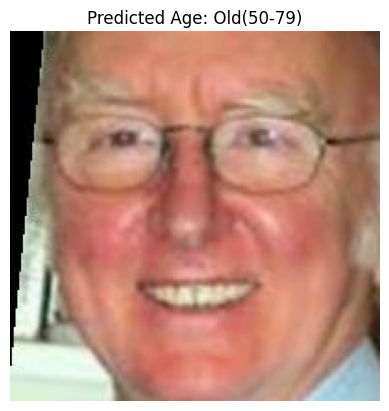

In [32]:
# random_test

def compute_hog_features_single(image_path):
    image = io.imread(image_path, as_gray=True)
    resized_image = transform.resize(image, (64, 64))
    hog_features = hog(resized_image, orientations=9, feature_vector=True)
    return hog_features

random_row = test_df.sample().values
random_image_path = random_row[0,0]
real_age = random_row[0,1]

test_hog_feature = compute_hog_features_single(random_image_path)
random_prediction = age_model.predict([test_hog_feature])

print(random_image_path)
print(random_prediction[0])
print(f"real age is : {real_age}")

image = io.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.title(f"Predicted Age: {AgeClasses[random_prediction[0]]}")
plt.axis('off')
plt.show()


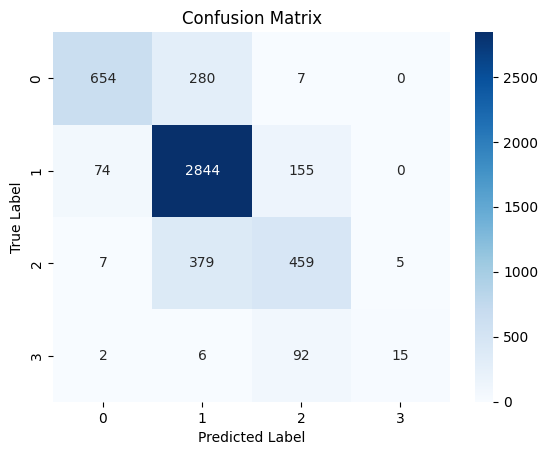

In [33]:

y_pred = age_model.predict(X_test_age)
cm = confusion_matrix(y_test_age, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

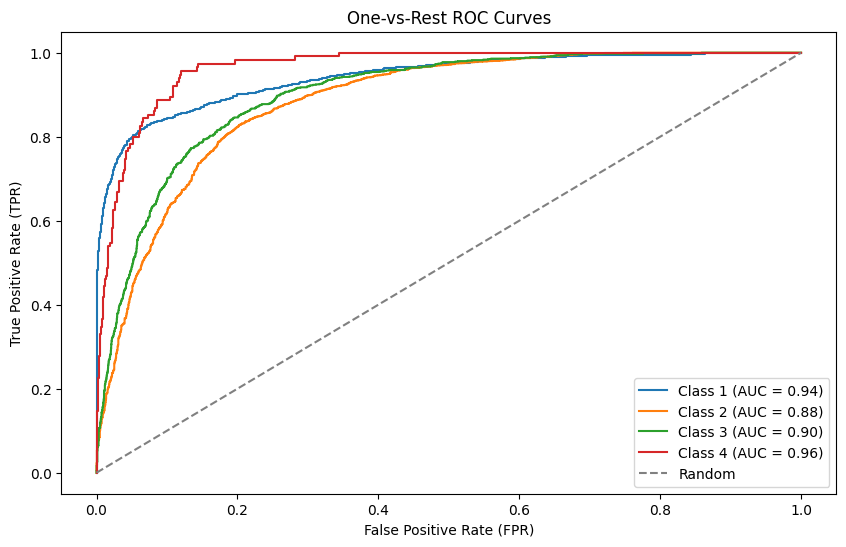

In [34]:
y_prob = age_model.predict_proba(X_test_age)

y_test_bin = label_binarize(y_test_age, classes=age_model.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(age_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(age_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-Rest ROC Curves')
plt.legend()
plt.show()

From the roc_curve we can conclude that the model excels in categorizing the classes in this order:\
Senior 0.96\
Kid    0.94\
Old    0.90\
Adult  0.88

Senior(80+) is the easiest, Adult(18-49) is the hardest

## KMeans Clustering

In [35]:
# Scale data by minmax 
Scaler = MinMaxScaler()
X = Scaler.fit_transform(X)
X


array([[0.2938705 , 0.05754752, 0.12961878, ..., 0.06827694, 0.02083954,
        0.01427842],
       [0.22282657, 0.06860709, 0.09933242, ..., 0.01002437, 0.03359555,
        0.02679737],
       [0.63173755, 0.55510797, 0.        , ..., 0.03706235, 0.03757428,
        0.10771977],
       ...,
       [0.04969985, 0.        , 0.        , ..., 0.01693847, 0.00248381,
        0.00757787],
       [0.55757023, 0.66682671, 0.25163415, ..., 0.30042864, 0.35553074,
        0.11096771],
       [0.1243951 , 0.06728392, 0.40095487, ..., 0.02733042, 0.07738601,
        0.28435052]])

In [36]:
max_clusters = 5 # as required in project docs

inertia = []
silhouette = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=400, init='k-means++', random_state=42)
    kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))


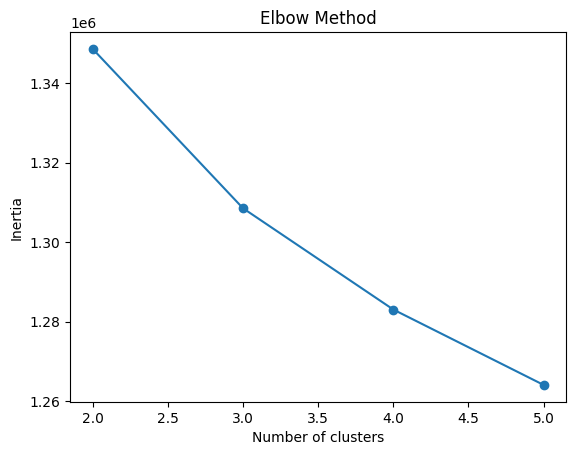

In [37]:
# plot the elbow graph with a maximum of 5 clusters
plt.plot(range(2, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [38]:
print(inertia)

[1348638.6569658874, 1308525.8054266379, 1283025.3397468503, 1264044.756615341]


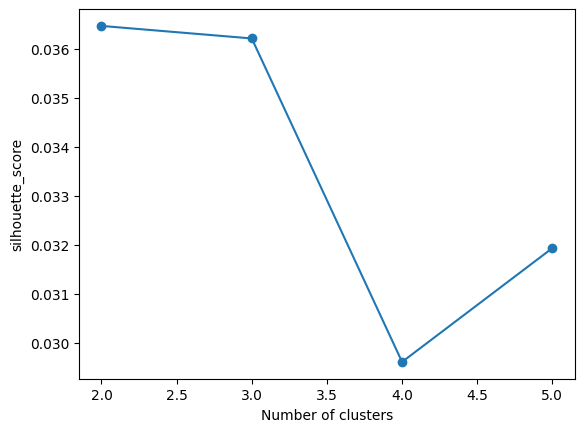

In [39]:
# plot the silhouette_score graph with a maximum of 5 clusters
plt.plot(range(2, max_clusters + 1), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()

In [40]:
print(silhouette)

[0.03647386268829695, 0.036217715935959134, 0.0296048447853517, 0.03193159148015512]


In [41]:
# best n cluster is 4 from the graph
kmean = KMeans(n_clusters=3, n_init=10, max_iter=400, init='k-means++', random_state=42)

clusters = kmean.fit_predict(X)
df['cluster'] = kmean.labels_

In [42]:
print(kmean.inertia_)
print(silhouette_score(X, df['cluster']))

1308525.8054266379
0.036217715935959134


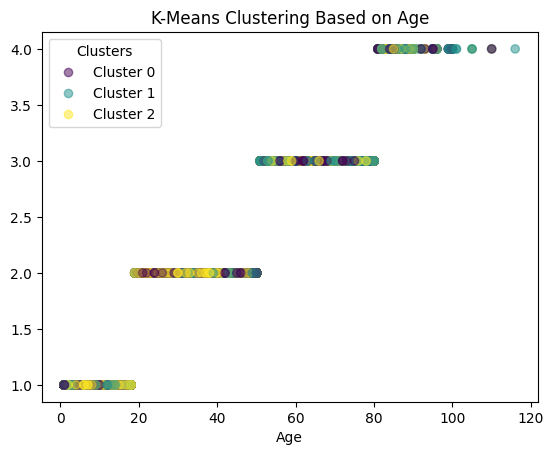

In [43]:
scatter = plt.scatter(df['age'], df['age_group'], c=clusters, cmap='viridis', alpha=0.5)

legend_labels = [f'Cluster {i}' for i in range(clusters.size)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.xlabel('Age')
plt.title('K-Means Clustering Based on Age')
plt.show()

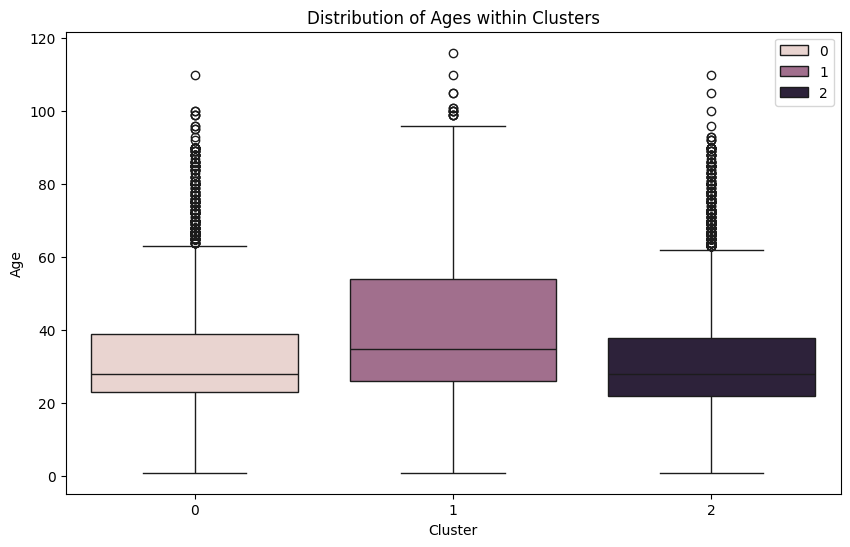

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=clusters, y='age', data=df, hue=clusters)
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Distribution of Ages within Clusters')
plt.show()

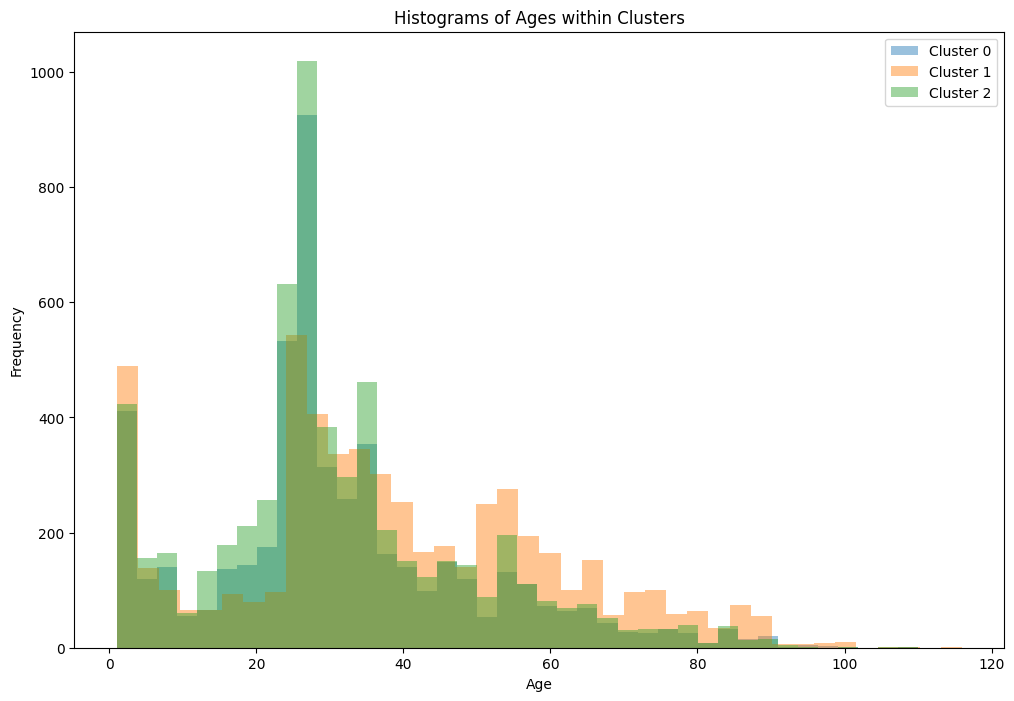

In [51]:
plt.figure(figsize=(12, 8))
for cluster_label, cluster_data in df.groupby(clusters):
    plt.hist(cluster_data['age'], bins=40, alpha=0.45, label=f'Cluster {cluster_label}')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Ages within Clusters')
plt.legend()
plt.show()